# **Multiclass Classification using Keras and TensorFlow on Food-101 Dataset**


### **Overview** 
* **Download and extract Food 101 dataset**
* **Understand dataset structure and files** 
* **Visualize random image from each of the 101 classes**
* **Split the image data into train and test using train.txt and test.txt**
* **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**
* **Fine tune Inception Pretrained model using Food 101 dataset**
* **Visualize accuracy and loss plots**
* **Predicting classes for new images from internet**
* **Scale up and fine tune Inceptionv3 model with 11 classes of data**
* **Model Explainability**
* **Summary of the things I tried**
* **Further improvements**
* **Feedback**

### **Download and extract Food 101 Dataset**

In [2]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [3]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.12.0
/device:GPU:0


In [4]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [5]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

* **Commented the below cell as the Food-101 dataset is available from Kaggle Datasets and need not be downloaded..**

In [6]:
# Download data and extract it to folder
# Uncomment this below line if you are on Colab

#get_data_extract()

### **Understand dataset structure and files**

**The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)**
* **This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)**
* **Each type of food has 750 training samples and 250 test samples**
* **Note found on the webpage of the dataset :  **  
***On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.***  
* **The entire dataset is 5GB in size**

In [7]:
# Check the extracted dataset folder
!ls food-101/

README.txt  images  license_agreement.txt  meta


**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [8]:
os.listdir('food-101/images')

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [9]:
os.listdir('food-101/meta')

['test.txt',
 'train.json',
 'labels.txt',
 'test.json',
 'train.txt',
 'classes.txt']

In [10]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [11]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

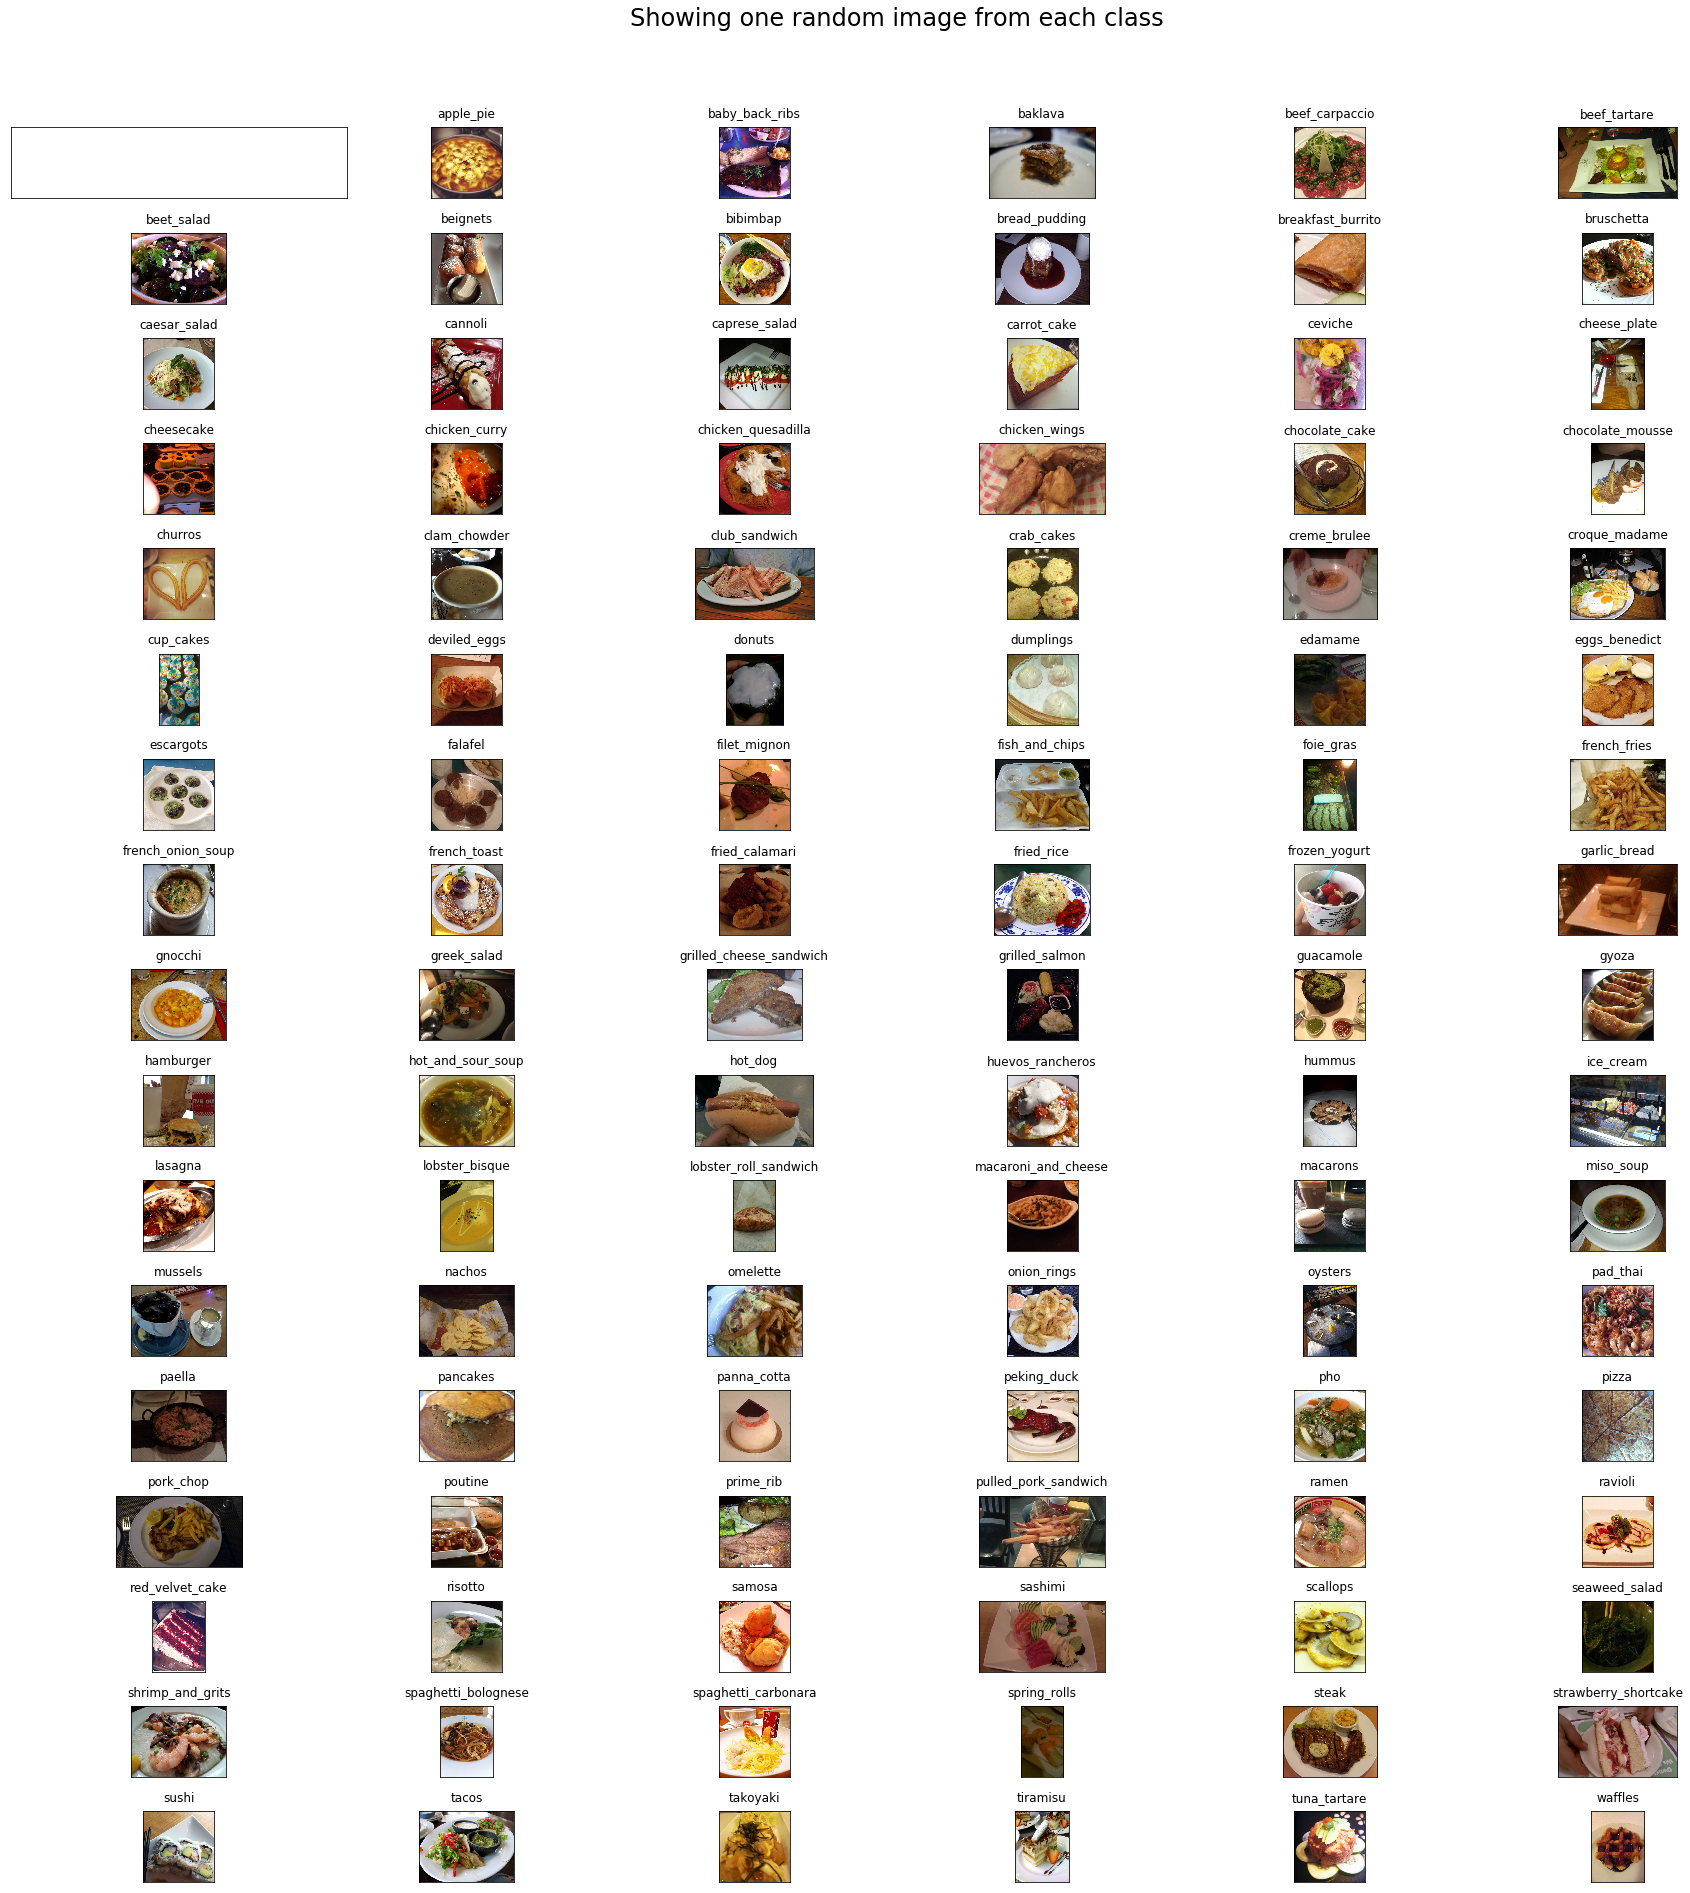

In [12]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


### **Split the image data into train and test using train.txt and test.txt**

In [13]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [14]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [15]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [16]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [17]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [21]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [22]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [23]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [24]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [25]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [26]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [27]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [28]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### **Fine tune Inception Pretrained model using Food 101 dataset**

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [30]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/10
139/140 [============================>.] - ETA: 0s - loss: 1.0619 - acc: 0.4825
Epoch 00001: val_loss improved from inf to 0.82816, saving model to best_model_3class.hdf5
140/140 [==============================] - 83s 590ms/step - loss: 1.0605 - acc: 0.4835 - val_loss: 0.8282 - val_acc: 0.7391
Epoch 2/10
139/140 [============================>.] - ETA: 0s - loss: 0.8275 - acc: 0.6991
Epoch 00002: val_loss improved from 0.82816 to 0.65057, saving model to best_model_3class.hdf5
140/140 [==============================] - 52s 369ms/step - loss: 0.8268 - acc: 0.6990 - val_loss: 0.6506 - val_acc: 0.8397
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 0.6657 - acc: 0.7840
Epoch 00003: val_loss improved from 0.65057 to 0.51930, saving model to best_model_3class.hdf5
140/140 [==============================] - 51s 364ms/step - loss: 0.6638 - acc: 0.7851 - val_loss: 0.5193 - val_acc

In [31]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

### **Visualize the accuracy and loss plots**

In [32]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


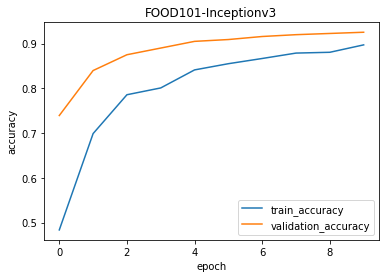

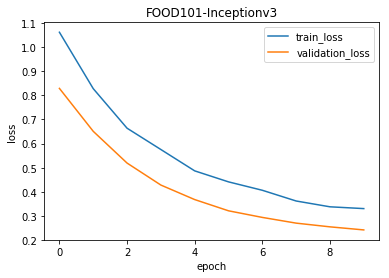

In [33]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* **The plots show that the accuracy of the model increased with epochs and the loss has decreased**
* **Validation accuracy has been on the higher side than training accuracy for many epochs**
* **This could be for several reasons:**
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy

 


### **Predicting classes for new images from internet using the best trained model**

In [34]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 9.8 s, sys: 150 ms, total: 9.95 s
Wall time: 9.89 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [35]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2024-08-20 18:20:41--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 104.21.79.5, 172.67.139.59, 2606:4700:3036::6815:4f05, ...
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|104.21.79.5|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg [following]
--2024-08-20 18:20:41--  https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|104.21.79.5|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-20 18:20:42 ERROR 404: Not Found.

--2024-08-20 18:20:43--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Conne

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
predict_class(model_best, images, True)

* **Yes!!! The model got them all right!!**

### **Fine tune Inceptionv3 model with 11 classes of data**

* **We trained a model on 3 classes and tested it using new data**
* ** The model was able to predict the classes of all three test images correctly**
* **Will it be able to perform at the same level of accuracy for more classes?**
* **FOOD-101 dataset has 101 classes of data**
* ** Even with fine tuning using a pre-trained model, each epoch was taking more than an hour when all 101 classes of data is used(tried this on both Colab and on a Deep Learning VM instance with P100 GPU on GCP)**
* **But to check how the model performs when more classes are included, I'm using the same model to fine tune and train on 11 randomly chosen classes**


In [18]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list
  

In [19]:
# Lets try with more classes, lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [20]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...


NameError: name 'dataset_mini' is not defined

In [ ]:
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')


In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

In [ ]:
plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

* **The plots show that the accuracy of the model increased with epochs and the loss has decreased**
* **Validation accuracy has been on the higher side than training accuracy for many epochs**
* **This could be for several reasons:**
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy 


In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

In [ ]:
# Downloading images from internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


# from google.colab import files
# image = files.upload()

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

* **The model did well even when the number of classes are increased to 11**
* **Model training on all 101 classes takes some time**
* **It was taking more than an hour for one epoch when the full dataset is used for fine tuning**

### **Model Explainability**

* **Human lives and Technology are blending more and more together**
* **The rapid advancements in technology over the past few years can be attributed to how Neural Networks have evolved**
* **Neural Networks and Deep Learning are now being used in so many fields and industries - healthcare, finance, retail, automative etc**
* **Thanks to the Deep Learning libraries which enable us to develop applications/models with few lines of code, which a decade ago only those with a lot of expertise and research could do**
* **All of this calls for the need to understand how neural networks do what they do and how they do it**
* **This has led to an active area of research - Neural Network Model Interpretability and Explainability**

![](https://s3-media2.fl.yelpcdn.com/bphoto/7BlRoSOG3AsAWHMPOaG7ng/ls.jpg)

* **Neural Networks learn incrementally**
* **How does a neural network know what is in the image and how does it conclude that its a dog?**
* **The best analogy to understand the incremental learning of the model here is to think about how we would hand sketch the dog**
* **You can't start right away by drawing eyes, nose, snout etc**
* **To have any of those dogly features, you need a lot of edges and curves**
* **You start with edges/lines, put many of them together**
* **Use edges with curves to sketch patterns**
* **The patterns with more finer details will help us draw the visible features of a dog like eyes, ears, snout etc**
* **Neural networks adopt a very similar process when they are busy detecting what's in the provided data examples**

![](https://images.deepai.org/publication-preview/visualizing-and-understanding-convolutional-networks-page-4-medium.jpg)

* **The above image is taken from the paper - [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)**
* **The image contains the features of a trained model along with the kind of objects they would detect**
* **In the first row and first column, we have a grid of edge detecting features in layer 1 and some curve detectors in layer 2 in the 2nd column**
* **The last column in 1st row are the kind of objects that get detected using those curvy features**
* **With layer three in 2nd row, the model starts looking for patterns with edges and curves**
* **The second column in second row contains examples of patterns that are detected in layer 3 of the model**
* **With layer 4, the model starts detecting parts of object specific features and in layer 5 the model knows what's in the image**

* **Using feature visualization, we can know what a neural network layer and its features are looking for**
* **Using attribution, we can understand how the features impact the output and what regions in the image led the model to the generated output**

### Let us now check the model we trained and understand how it sees and classifies

* **Load the saved model and a test image**

In [ ]:
# Load the saved model trained with 3 classes
K.clear_session()
print("Loading the model..")
model = load_model('best_model_3class.hdf5',compile = False)
print("Done!")


* **Summary of the model gives us the list of all the layers in the network along with other useful details**

In [ ]:
model.summary()

* **Defining some helper functions**

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    plt.imshow(img[0])
    plt.show()
    return model_activations.predict(img)
    

In [ ]:
def show_activations(activations, layer_names):
    
    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()



**Check how many layers are in the trained model(this includes the 1st input layer as well)**

In [ ]:
len(model.layers)

* **Can we visualize the outputs of all the layers?**
* **Yes, we can. But that gets too tedious**
* **So, let's choose a few layers to visualize**

In [ ]:
# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)

**As seen below, the 10 chosen layers contain 3 convolution, 3 batch normalization, 3 activation and 1 max pooling layers**

In [ ]:
layers

**Get the names of all the selected layers**

In [ ]:
layer_names = []
for layer in model.layers[1:11]:
    layer_names.append(layer.name)
print(layer_names)

**Provide an input to the model and get the activations of all the 10 chosen layers**

In [ ]:
food = 'applepie.jpg'
activations = get_activations(food,activations_output)

* **activations** contain the outputs of all the 10 layers which can be plotted and visualized

**Visualize the activations of intermediate layers from layer 1 to 10**

In [ ]:
show_activations(activations, layer_names)

* **What we see in the above plots are the activations or the outputs of each of the 11 layers we chose**  
* **The activations or the outputs from the 1st layer(conv2d_1) don't lose much information of the original input**
* **They are the results of applying several edge detecting filters on the input image**
* **With each added layer, the activations lose visual/input information and keeps building on the class/ouput information**
* **As the depth increases, the layers activations become less visually interpretabale and more abstract**
* **By doing so, they learn to detect more specific features of the class rather than just edges and curves**
* **We plotted just 10 out of 314 intermediate layers. We already have in these few layers, activations which are blank/sparse(for ex: the 2 blank activations in the layer activation_1)**
* **These blank/sparse activations are caused when any of the filters used in that layer didn't find a matching pattern in the input given to it**
* **By plotting more layers(specially those towards the end of the network), we can observe more of these sparse activations and how the layers get more abstract**


**Get the activations for a different input / food**

In [ ]:
food = 'pizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

* **The feature maps in the above activations are for a different input image**
* **We see the same patterns discussed for the previous input image**
* **It is interesting to see the blank/sparse activations in the same layer(activation_1) and for same filters when a different image is passed to the network**
* **Remember we used a pretrained Inceptionv3 model. All the filters that are used in different layers come from this pretrained model**

### **Look into the sparse activations in the layer activation_1**

* **We have two blank/sparse activations in layer 6**
* **Below cell displays one of the sparse activations**

In [ ]:
# Get the index of activation_1 layer which has sparse activations
ind = layer_names.index('activation_1')
sparse_activation = activations[ind]
a = sparse_activation[0, :, :, 13]
a

In [ ]:
all (np.isnan(a[j][k])  for j in range(a.shape[0]) for k in range(a.shape[1]))

* **We can see that the activation has all nan values(it was all zeros when executed outside Kaggle, Im yet to figure out why its showing all nan values here**
* **To know why we have all zero/nan values for this activation, lets visualize the activation at same index 13 from previous layer**

In [ ]:
# Get the index of batch_normalization_1 layer which has sparse activations
ind = layer_names.index('batch_normalization_1')
sparse_activation = activations[ind]
b = sparse_activation[0, :, :, 13]
b

*  **All the values in the above activation map from the layer batch_normalization_1 are negative**
* **This activation in batch_normalization_1 is passed to the next layer activation_1 as input**
* **As the name says, activation_1 is an activation layer and ReLu is the activation function used**
* **ReLu takes an input value, returns 0 if its negative, the value otherwise**
* **Since the input to activation array contains all negative values, the activation layer fills its activation map with all zeros for the index**
* **Now we know why we have those 2 sparse activations in activation_1 layer**

**Show the activation outputs of 1st, 2nd and 3rd Conv2D layer activations to compare how layers get abstract with depth**

In [ ]:
first_convlayer_activation = activations[0]
second_convlayer_activation = activations[3]
third_convlayer_activation = activations[6]
f,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(first_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[0].axis('OFF')
ax[0].set_title('Conv2d_1')
ax[1].imshow(second_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[1].axis('OFF')
ax[1].set_title('Conv2d_2')
ax[2].imshow(third_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[2].axis('OFF')
ax[2].set_title('Conv2d_3')


### **Attribution**
* **So far we were doing activation maps visualization**  
* **This helps in understanding how the input is transformed from one layer to another as it goes through several operations**  
* **At the end of training, we want the model to classify or detect objects based on features which are specific to the class**  
* **For example, when training a dogs vs cats classifier, the model should detect dogs based on features relevant to dog but not cats**  
* **To validate how model attributes the features to class output, we can generate heat maps using gradients to find out which regions in the input images were instrumental in determining the class**  

In [ ]:
def get_attribution(food):
    img = image.load_img(food, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

In [ ]:
print("Showing the class map..")
print(class_map_3)

In [ ]:
pred = get_attribution('applepie.jpg')
print("Here are softmax predictions..",pred)

* **In the above plot, we see on left the input image passed to the model, heat map in the middle and the class activation map on right**  
* **Heat map gives a visual of what regions in the image were used in determining the class of the image**  
* **Now it's clearly visible what a model looks for in an image if it has to be classified as an applepie!**

###  **See how the class activation map looks for a different image**

In [ ]:
pred = get_attribution('pizza.jpg')
print("Here are softmax predictions..",pred)

* **We can see how the heat map is different for a different image i.e the model looks for a totally different features/regions if it has to classify it as a pizza**

### **Lets see if we can break the model or see what it does when we surpise it with different data!**

* **We trained our model to perform multi class classification and it seems to be doing well with >95% of accuracy**
* **What will the model do when we give it an image which has more than one object that model is trained to classify?**

In [ ]:
!wget -O piepizza.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizza.jpg
!wget -O piepizzas.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizzas.png
!wget -O pizzapie.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapie.jpg
!wget -O pizzapies.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapies.png    

In [ ]:
food = 'piepizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

In [ ]:
pred = get_attribution('piepizza.jpg')
print("Here are softmax predictions..",pred)

* **Given an image with pizza and applepie, the model thinks its a pizza with 75.4% confidence and an applie pie with 18% confidence**
* **Now let's flip the image vertically and see what the model does**

In [ ]:
food = 'pizzapie.jpg'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('pizzapie.jpg')
print("Here are softmax predictions..",pred)

* **Well, the model flipped its output too!**
* **The model now thinks its an apple pie with 49.7% confidence and a pizza with 31.9%**

### **More surprise data to the model...**

In [ ]:
food = 'pizzapies.png'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('pizzapies.png')
print("Here are softmax predictions..",pred)

* **This time it's applie pie with 73% and a pizza with 19% confidence**
* **Let's try one last horizontal flip, this is the last really!**

In [ ]:
food = 'piepizzas.png'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('piepizzas.png')
print("Here are softmax predictions..",pred)

* **No surprise from model this time. We flipped the image but the model didnt flip its output**
* **It's an apple pie again with 52% confidence**



### QUESTION!
* **But hey, we did not train our model to do multi label classification. So why are we giving it input images with multiple classes?**

### ANSWER 
* **Once we train a model, it is also necessary to try it in a way we know it may not work(like giving images with multiple classes of objects in it). This will lead to new observations, insights and maybe new conclusions if not inventions!**
* **Flipping the image vertically has flipped the outputs whereas doing a horizontal flip didnt cause any change in output class**
* **As a next step, we can try with more images, from different classes and check if the same pattern exists**

### **Summary of the things I tried**
* **This notebook is the refactored and organised version of all the experiments and training trials I made**
* **I used this very useful Keras blog - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html for reference**
* **I spent considerable amount of time in fixing things even before getting to the model training phase**
* **For example, it took some time to get the image visualization plots aligned withouth any overlap**
* **It is easier to go through a notebook and understand code someone else has taken hours to finish**
* **I started with VGG16 pretrained model. It did give good validation accuracy after training for few epochs**
* **I then tried Inceptionv3. VGG was taking more time for each epoch and since inception was also giving good validation accuracy, I chose Inception over VGG**
* **For data augmentation, I sticked to the transformations used in the above blog**
* **I didnt use TTA except rescaling test images**
* **Model explainability helped me understand many new things**
* **Once we train a model, it is also necessary to try it in a way we know it may not work(like giving images with multiple classes of objects in it). This will lead to new observations, insights and maybe new conclusions if not inventions!**

### **Further Improvements**
* **Try more augmentation on test images**
* **Fine tune the model on the entire dataset(for a few epochs atleast)**
* **Play with hyper parameters, their values and see how it impacts model performance**
* **There is currently no implementation to handle out of distribution / no class scenario. Can try below methods:**
    * Set a threshold for the class with highest score. When model gives prediction score below the threshold for its top prediction, the prediction can be classified as NO-CLASS / UNSEEN
    * Add a new class called **NO-CLASS**, provide data from different classes other than those in the original dataset. This way the model also learns how to classify totally unseen/unrelated data
    * I am yet to try these methods and not sure about the results
* **Recently published paper - [Rethinking ImageNet Pretraining](https://arxiv.org/abs/1811.08883 ), claims that training from random initialization instead of using pretrained weights is not only robust but also gives comparable results**
* **Pre-trained models are surely helpful. They save a lot of time and computation. Yet, that shouldn't be the reason to not try to train a model from scratch**
* **Time taking yet productive experiment would be to try and train a model on this dataset from scratch**
* **Do more experiments with Model Interpretability and see what can be observed**

### **References**
* **Deep Learning with Python by Francois Cholett - must read really!**
* [Building Powerful Image Classification Models](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [How Convolutional Neural Networks See the World](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
* [Feature Visualization](https://distill.pub/2017/feature-visualization/)